In [1]:
from analysis_classes import *
import os

dataset_directory = "../csv_to_protobuf_bin/binary_logs/AWS_FXS/"

binary_datasets = os.listdir(dataset_directory)

# labels_ = "89"
binary_datasets_name_dict = {}

for i, name in enumerate(binary_datasets):
    # if labels_ in i:
    #     dtns_data.append(i)
    binary_datasets_name_dict[i] = name
print(binary_datasets_name_dict)
# round5 : 1 round - each round 3 minutes- 10 seconds wait- without clearing cache table and only using vm touch. Simple sender and reciever buffer size is 1 MB. - HDD osts
# * round7 : 2 round - each round 3 minutes- 10 seconds wait- clearing cache table and using vm touch as well. Simple sender and reciever buffer size is 1 MB. - HDD osts

# round8 : 1 reound - each round 6 time 30 seconds - 10 seconds wait- with clearing cache and using vm touch as well. Simple sender and reciever buffer size is 1 MB.- SSD osts
# * round9 : 2 reound - each round 6 time 30 seconds - 10 seconds wait- with clearing cache and using vm touch as well. Simple sender and reciever buffer size is 1 MB.- SSD osts
# round10 : 2 reound - each round 6 time 30 seconds - 10 seconds wait- with clearing cache and using vm touch as well. Simple sender and reciever buffer size is 1 MB.- SSD osts - No write congestion from other clients on sender used ost

# series 11:  1 reound - each round 6 time 30 seconds - 10 seconds wait- with clearing cache and using vm touch as well. Simple sender and reciever buffer size is 1 MB.- SSD ost - sender and receiver metrics

{0: 'round10', 1: 'round6', 2: 'round1', 3: 'round9', 4: 'round5', 5: 'series12', 6: 'round2', 7: 'series11', 8: 'round7', 9: 'series13'}


In [2]:
# loading data sets
print("Total number of  datasets in directory {} is \t{}".format(dataset_directory, len(binary_datasets_name_dict)))
# hdd_round7_dataset_name = binary_datasets_name_dict[6]
# hdd_round7_ta_obj = TransferAnalysis(dataset_directory + hdd_round7_dataset_name)
# hdd_round7_df = hdd_round7_ta_obj.df

# ssd_round_9_dataset_name = binary_datasets_name_dict[6]
# ssd_round_9_ta_obj = TransferAnalysis(dataset_directory + ssd_round_9_dataset_name)
# ssd_round_9_df = ssd_round_9_ta_obj.df

ssd_round_11_dataset_name = binary_datasets_name_dict[7]
ssd_round_11_ta_obj = TransferAnalysis(dataset_directory + ssd_round_11_dataset_name)
ssd_round_11_df = ssd_round_11_ta_obj.df


hdd_round_12_dataset_name = binary_datasets_name_dict[5]
hdd_round_12_ta_obj = TransferAnalysis(dataset_directory + hdd_round_12_dataset_name)
hdd_round_12_df = hdd_round_12_ta_obj.df


ssd_round_13_dataset_name = binary_datasets_name_dict[9]
ssd_round_13_ta_obj = TransferAnalysis(dataset_directory + ssd_round_13_dataset_name)
ssd_round_13_df = ssd_round_13_ta_obj.df


Total number of  datasets in directory ../csv_to_protobuf_bin/binary_logs/AWS_FXS/ is 	10


In [3]:
from pathlib import Path

chosen_dataset_name = ssd_round_11_dataset_name
dtns_df = ssd_round_11_df
print("Dataframe shape for dtns dataset {} is : {}\n".format(chosen_dataset_name, dtns_df.shape))
print("Number of keys in the dataframe for dataset {} is {}\n".format(chosen_dataset_name, len(ssd_round_11_df.keys())))

basic_saving_dir = "./{}/".format(chosen_dataset_name)
Path(basic_saving_dir).mkdir(parents=True, exist_ok=True)

Dataframe shape for dtns dataset series11 is : (8545, 117)

Number of keys in the dataframe for dataset series11 is 117



In [4]:
print ("Total number of different labels in dataset {} is {}".format(chosen_dataset_name, len(dict(Counter(dtns_df[dtns_df.columns[len(dtns_df.columns) - 1]]))) ))

Total number of different labels in dataset series11 is 81


In [5]:
def train_test_split_df(df):
    df = df.sample(frac=1).reset_index(drop=True)
    X = df.drop(df.columns[len(df.columns) - 1], axis=1)
    y = df[df.columns[len(df.columns) - 1]]
    # total_labels = len(dict(Counter(y)))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [6]:
# merge two sets of write congestions together
g_label = GroupedLabels(total_possible_labels=90)
print ("Before merging labels:\nTotal number of different labels in dataset {} is {}\n".format(chosen_dataset_name, len(dict(Counter(dtns_df[dtns_df.columns[len(dtns_df.columns) - 1]]))) ))
levels_merged_df = g_label.grouped_levels_cate(df=dtns_df)
print ("After merging labels of different levels:\nTotal number of different labels in dataset {} is {}\n".format(chosen_dataset_name, len(dict(Counter(dtns_df[dtns_df.columns[len(dtns_df.columns) - 1]]))) ))
# dtns_df = g_label.grouped_levels_cate(df=dtns_df)
# dtns_df = g_label.grouped_write_cate(df=dtns_df)
# print (dtns_df["label_value"])

Before merging labels:
Total number of different labels in dataset series11 is 81

After merging labels of different levels:
Total number of different labels in dataset series11 is 18



In [7]:
# Running a model with a data set default model is random forest
a_model = Model_Run()
levels_merged_x_dtns_train, levels_merged_x_dtns_test, levels_merged_y_dtns_train, levels_merged_y_dtns_test = train_test_split_df(levels_merged_df)
print("Accuracy of the model {} on dataset {} is after merging different levels".format(a_model.model_to_name[a_model.model_name], chosen_dataset_name), a_model.run_model(df=levels_merged_df))

levels_merged_rf_model = a_model.generate_with_all(levels_merged_x_dtns_train, levels_merged_y_dtns_train)


Accuracy of the model Random Forest on dataset series11 is after merging different levels 0.9894675248683441


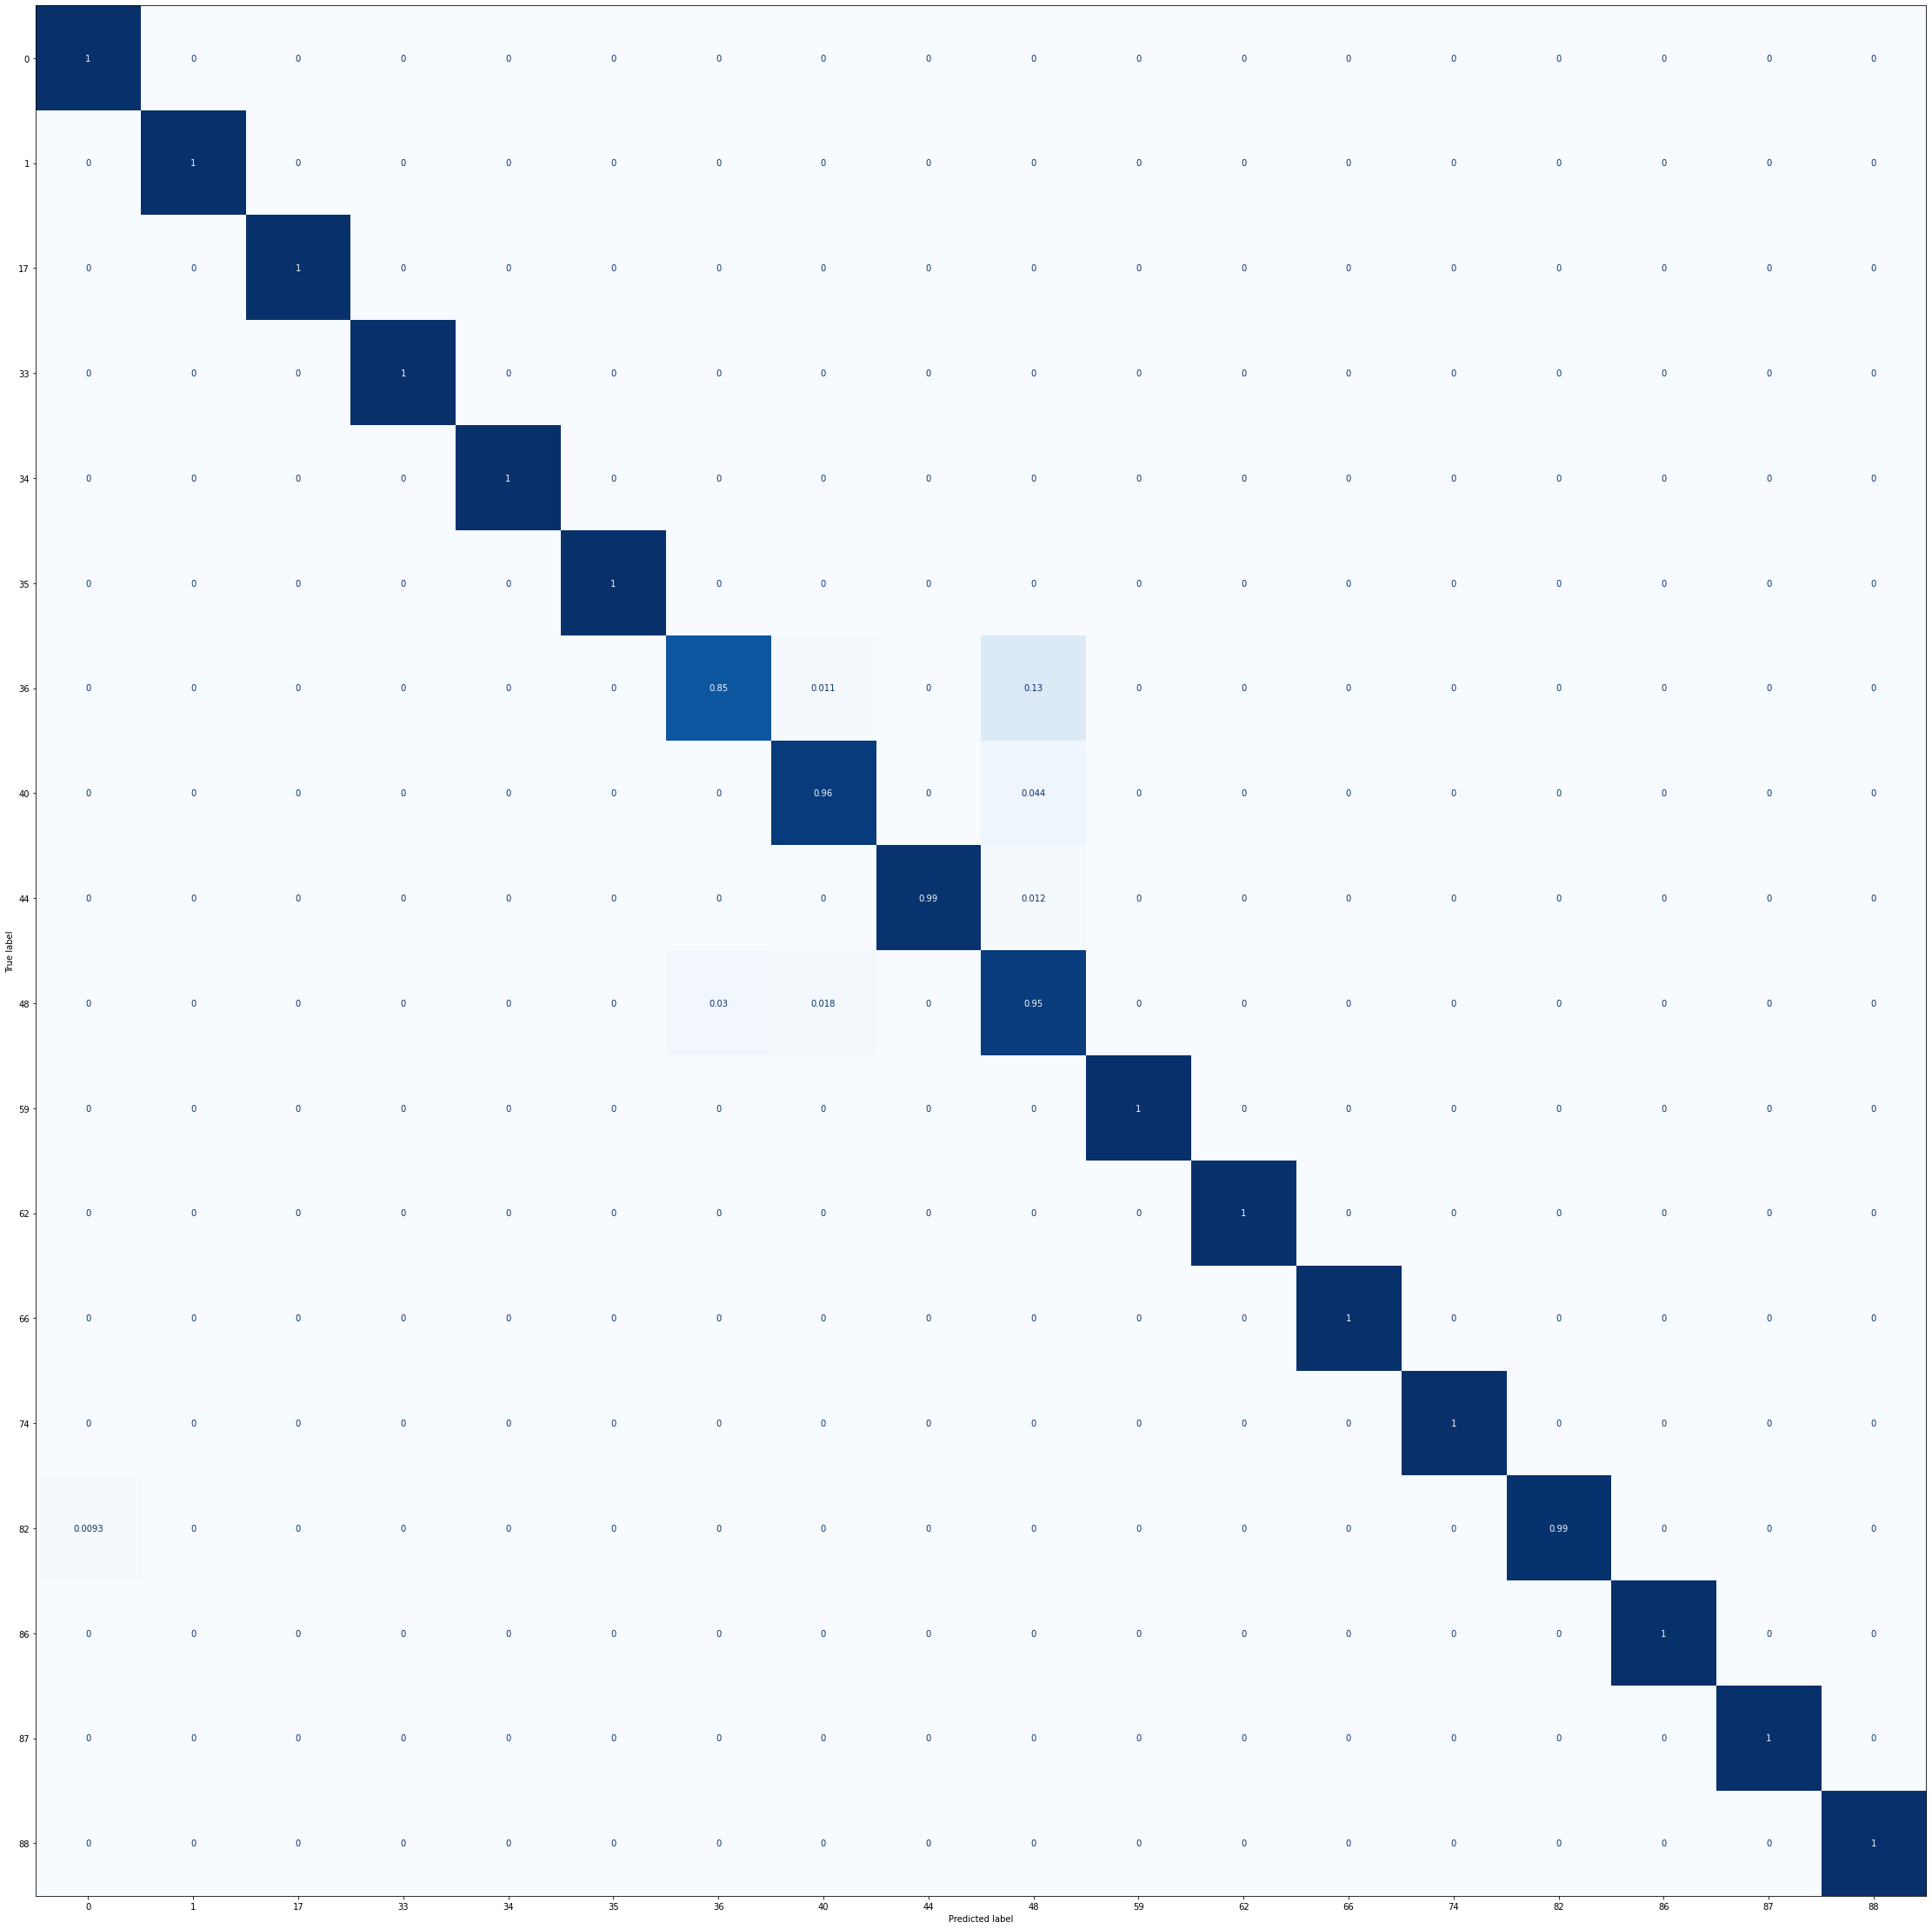

In [8]:
# creating confusion matrix for the chosen dataset and model
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

levels_merged_y_predicted = levels_merged_rf_model.predict(levels_merged_x_dtns_test)
fig, ax = plt.subplots(figsize=(40, 40))
disp = ConfusionMatrixDisplay.from_predictions(levels_merged_y_dtns_test, levels_merged_y_predicted,
                                               labels=levels_merged_rf_model.classes_, normalize='true',
                                               cmap=plt.cm.Blues, ax=ax, colorbar=False)
file_name ='grouped_all_levels_dataset_{}_confusion_matrix.jpg'.format(chosen_dataset_name)
save_path = "{}/{}".format(basic_saving_dir, file_name)
fig.savefig(save_path, dpi=100)


Elapsed time to compute the importances: 0.0039730072021484375
Total numebr of features in the trained model is 116


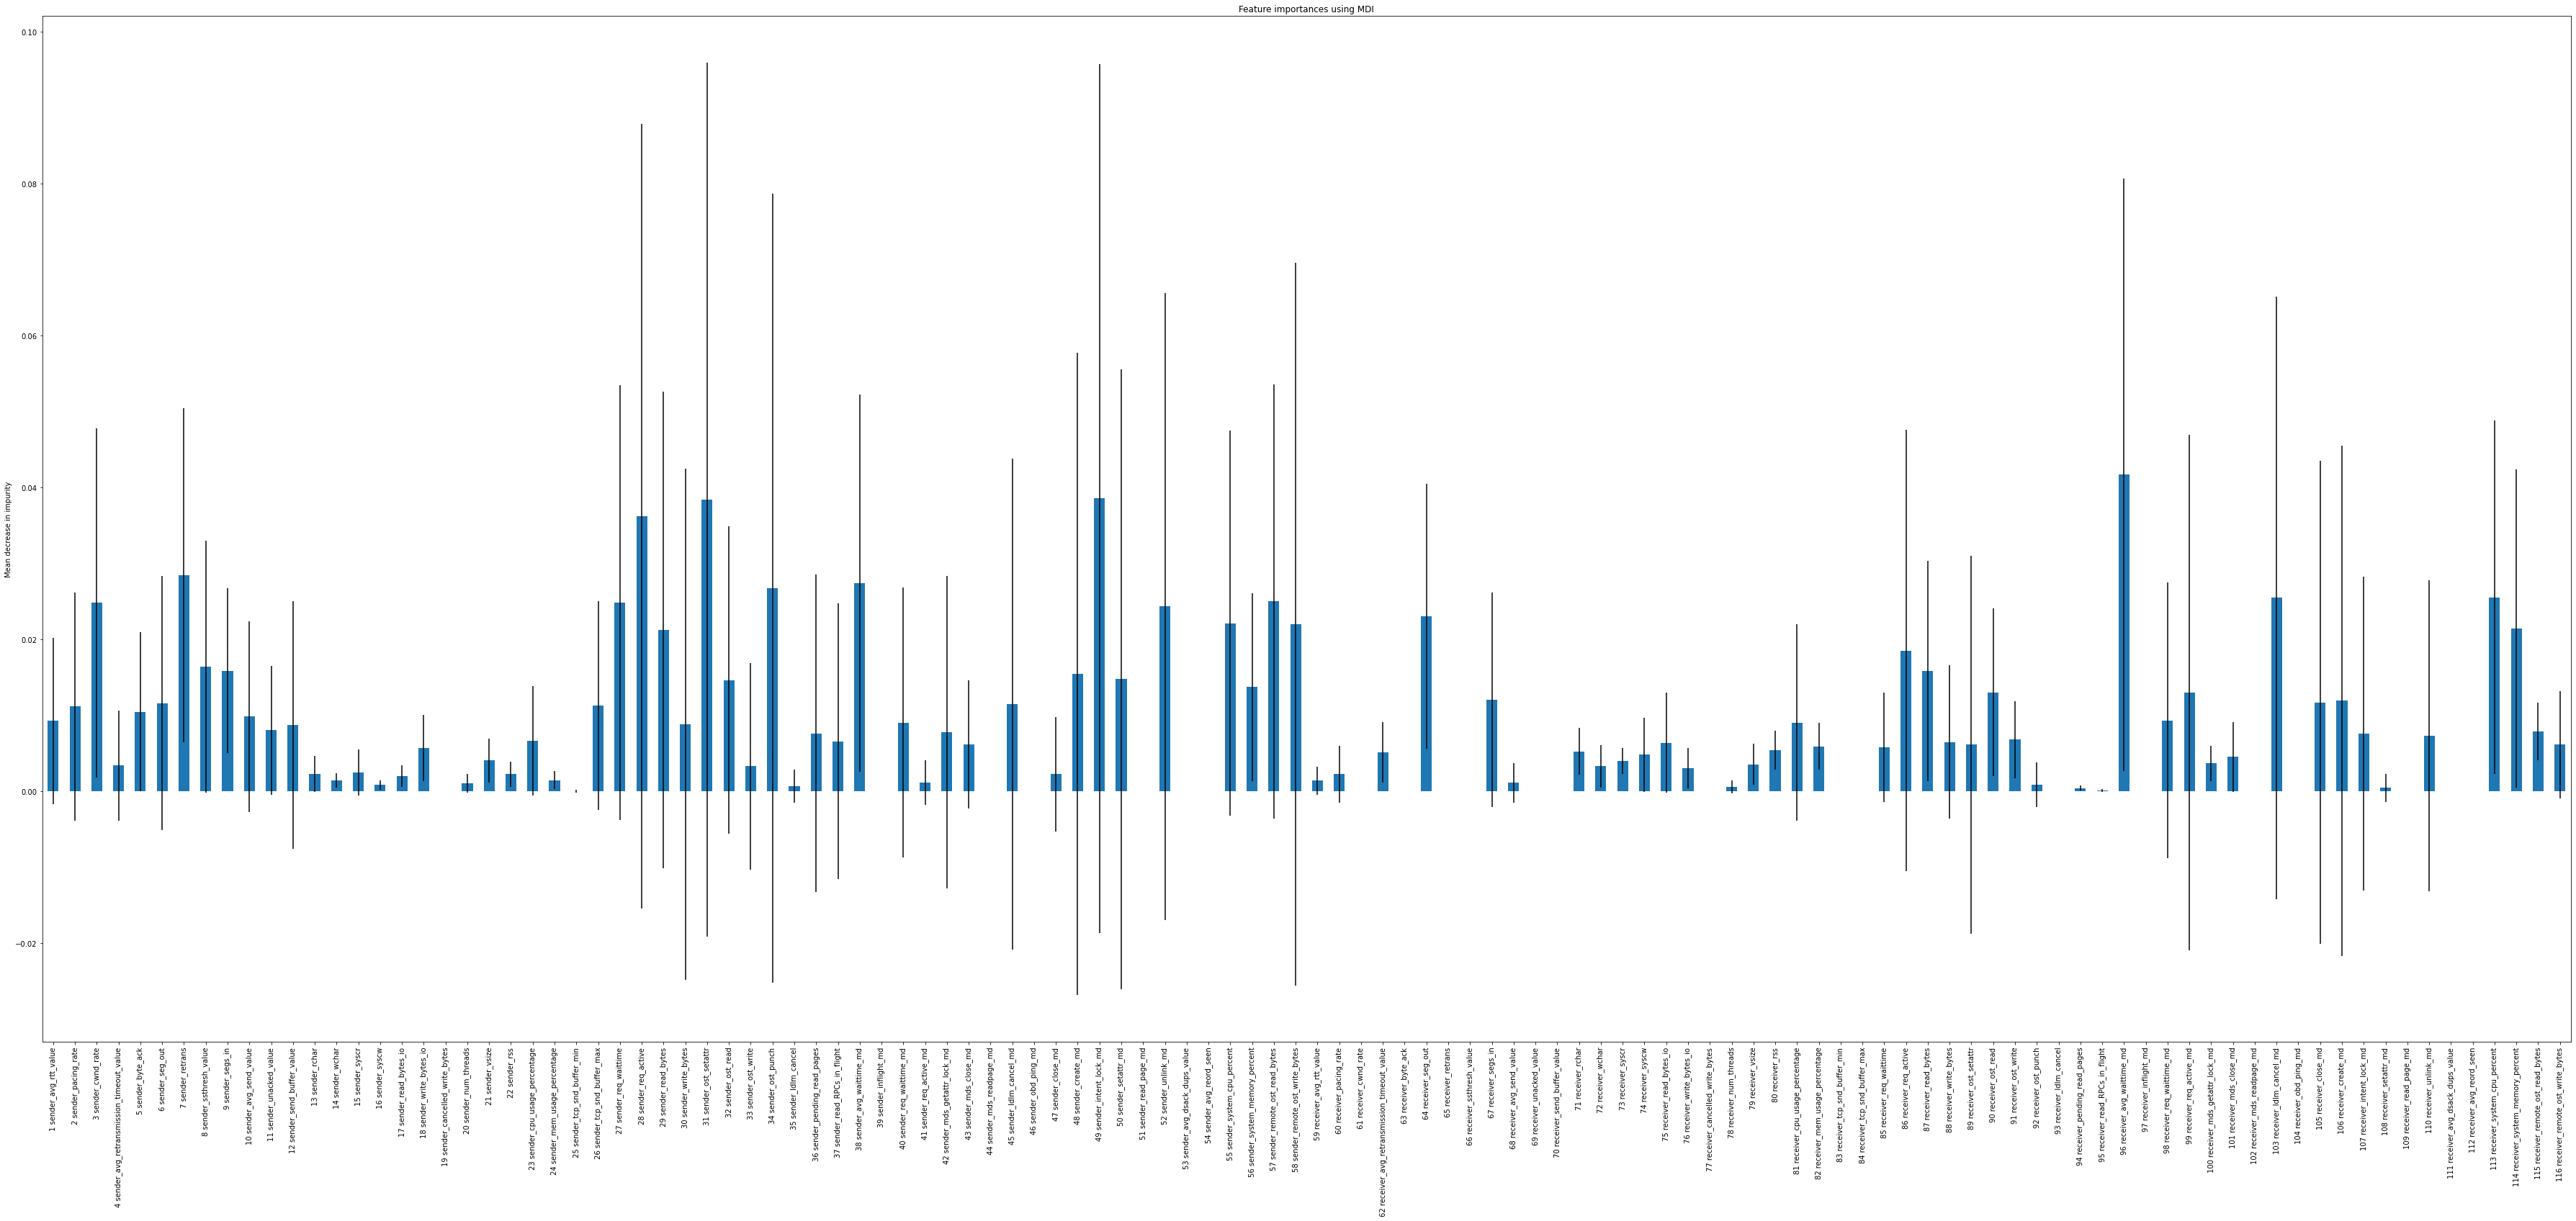

In [9]:
import time
import numpy as np
import pandas as pd

start_time = time.time()
importances = levels_merged_rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in levels_merged_rf_model.estimators_], axis=0)
elapsed_time = time.time() - start_time
print("Elapsed time to compute the importances: {}".format(elapsed_time))
# print(f"Elapsed time to compute the importances: " f"{elapsed_time:.3f} seconds")

feature_names = np.array([str(i + 1) + " " + str(j) for i, j in enumerate(dtns_df.columns[:-1])])
# print(len(feature_names))
print("Total numebr of features in the trained model is {}".format(len(feature_names)))
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.set_size_inches(50, 25)
file_name ='model3_grouped_all_levels_dataset_{}_feature_importance.jpeg'.format(chosen_dataset_name)
save_path = "{}/{}".format(basic_saving_dir, file_name)
fig.savefig(save_path, dpi=100)
fig.tight_layout()

In [14]:

importances_copy = importances
all_keys = ssd_round_11_ta_obj.sender_keys + ssd_round_11_ta_obj.receiver_keys
# print(all_keys)
feature_names = np.array([i for i in dtns_df.columns[:-1]])

accuracy_list = np.array([])
feature_numbers = np.array([])
selected_features_name =  []
# len(importances) + 1
for n_max_value in range(1, len(importances) + 1):
    print("Getting {}th maximum valuable feature to train a model".format(n_max_value))
    # Get indices of n max important features based on the importance array
    max_indices = np.argpartition(importances_copy, np.negative(n_max_value))[np.negative(n_max_value):]
    # print(n_max_value, max_indices)
    # print(max_indices, len(ssd_round_9_ta_obj.sender_keys))
    sender_selected_key_indices = np.delete(max_indices, np.where(max_indices > len(ssd_round_11_ta_obj.sender_keys)))
    receiver_selected_indices = np.delete(max_indices, np.where(max_indices <= len(ssd_round_11_ta_obj.sender_keys)))

    # selected_key = np.concatenate((np.take(all_keys, max_indices), []))
    sender_selected_key = np.concatenate((np.take(all_keys, sender_selected_key_indices), []))
    receiver_selected_key = np.concatenate((np.take(all_keys, receiver_selected_indices), []))
    # print(sender_selected_key_indices, sender_selected_key)
    # print(receiver_selected_indices, receiver_selected_key)

    selected_features = np.take(feature_names, max_indices)
    temp_df = TransferAnalysis(dataset_directory + ssd_round_11_dataset_name, sender_selected_key, receiver_selected_key).df
    grouped_temp_df = g_label.grouped_levels_cate(df=temp_df)
    # # grouped_temp_df = g_label.grouped_write_cate(df=temp_df)
    temp_model = Model_Run()
    x_dtns_train, x_dtns_test, y_dtns_train, y_dtns_test = train_test_split_df(temp_df)
    acc = temp_model.run_model(df=grouped_temp_df)
    accuracy_list = np.append(accuracy_list, np.round(acc * 100, 2))
    feature_numbers = np.append(feature_numbers, n_max_value)
    selected_features_name.append(selected_features)
    # print("Accuracy of {} on dataset {} with\t{} most important features is".format(
    #     temp_model.model_to_name[temp_model.model_name],
    #     ssd_round_9_dataset_name,
    #     n_max_value), acc)


Getting 1th maximum valuable feature to train a model
Getting 2th maximum valuable feature to train a model
Getting 3th maximum valuable feature to train a model
Getting 4th maximum valuable feature to train a model
Getting 5th maximum valuable feature to train a model
Getting 6th maximum valuable feature to train a model
Getting 7th maximum valuable feature to train a model
Getting 8th maximum valuable feature to train a model
Getting 9th maximum valuable feature to train a model
Getting 10th maximum valuable feature to train a model
Getting 11th maximum valuable feature to train a model
Getting 12th maximum valuable feature to train a model
Getting 13th maximum valuable feature to train a model
Getting 14th maximum valuable feature to train a model
Getting 15th maximum valuable feature to train a model
Getting 16th maximum valuable feature to train a model
Getting 17th maximum valuable feature to train a model
Getting 18th maximum valuable feature to train a model
Getting 19th maximu

In [11]:
selected_features_name =  []
importances_copy = importances
feature_names = np.array([i for i in dtns_df.columns[:-1]])
feature_numbers = np.array([])

selected_features_name_sorted_array = []
previous_max_indices = np.array([])

for n_max_value in range(1, len(importances) + 1):
    max_indices = np.argpartition(importances_copy, np.negative(n_max_value))[np.negative(n_max_value):]
    new_max_indices = max_indices
    for i in previous_max_indices:
        new_max_indices = np.delete(new_max_indices, np.where(new_max_indices == i))
    previous_max_indices = max_indices
    selected_features = np.take(feature_names, max_indices)
    new_selected_feature = np.take(feature_names, new_max_indices)
    feature_numbers = np.append(feature_numbers, n_max_value)
    selected_features_name.append(selected_features)
    # selected_features_name_sorted_array.append(new_selected_feature)
    if len(selected_features_name_sorted_array) > 0:
        selected_features_name_sorted_array.append(np.concatenate((selected_features_name_sorted_array[-1], new_selected_feature)))
    else:
        selected_features_name_sorted_array.append(new_selected_feature)

text=""
text_sorted=""
for i in range(len(feature_numbers)):
    names = ""
    names_sorted = ""
    for name in selected_features_name[i]:
        names += "{}, ".format(name)
    for name_s in selected_features_name_sorted_array[i]:
        names_sorted += "{}, ".format(name_s)
    text += "{}:    {}\n\n".format('{0:0{1}}'.format(int(feature_numbers[i]), 3), names)
    text_sorted += "{}:    {}\n\n".format('{0:0{1}}'.format(int(feature_numbers[i]), 3), names_sorted)
# print(text)
print(text_sorted)


save_path = "{}/{}".format(basic_saving_dir, 'model3_selected_features_name_sorted.txt')
with open(save_path, 'w') as f:
    data = f.write(text_sorted)

save_path = "{}/{}".format(basic_saving_dir, 'model3_selected_features_name.txt')
with open(save_path, 'w') as f:
    data = f.write(text)

001:    receiver_avg_waittime_md, 

002:    receiver_avg_waittime_md, sender_intent_lock_md, 

003:    receiver_avg_waittime_md, sender_intent_lock_md, sender_ost_setattr, 

004:    receiver_avg_waittime_md, sender_intent_lock_md, sender_ost_setattr, sender_req_active, 

005:    receiver_avg_waittime_md, sender_intent_lock_md, sender_ost_setattr, sender_req_active, sender_retrans, 

006:    receiver_avg_waittime_md, sender_intent_lock_md, sender_ost_setattr, sender_req_active, sender_retrans, sender_avg_waittime_md, 

007:    receiver_avg_waittime_md, sender_intent_lock_md, sender_ost_setattr, sender_req_active, sender_retrans, sender_avg_waittime_md, sender_ost_punch, 

008:    receiver_avg_waittime_md, sender_intent_lock_md, sender_ost_setattr, sender_req_active, sender_retrans, sender_avg_waittime_md, sender_ost_punch, receiver_system_cpu_percent, 

009:    receiver_avg_waittime_md, sender_intent_lock_md, sender_ost_setattr, sender_req_active, sender_retrans, sender_avg_waittime_md,

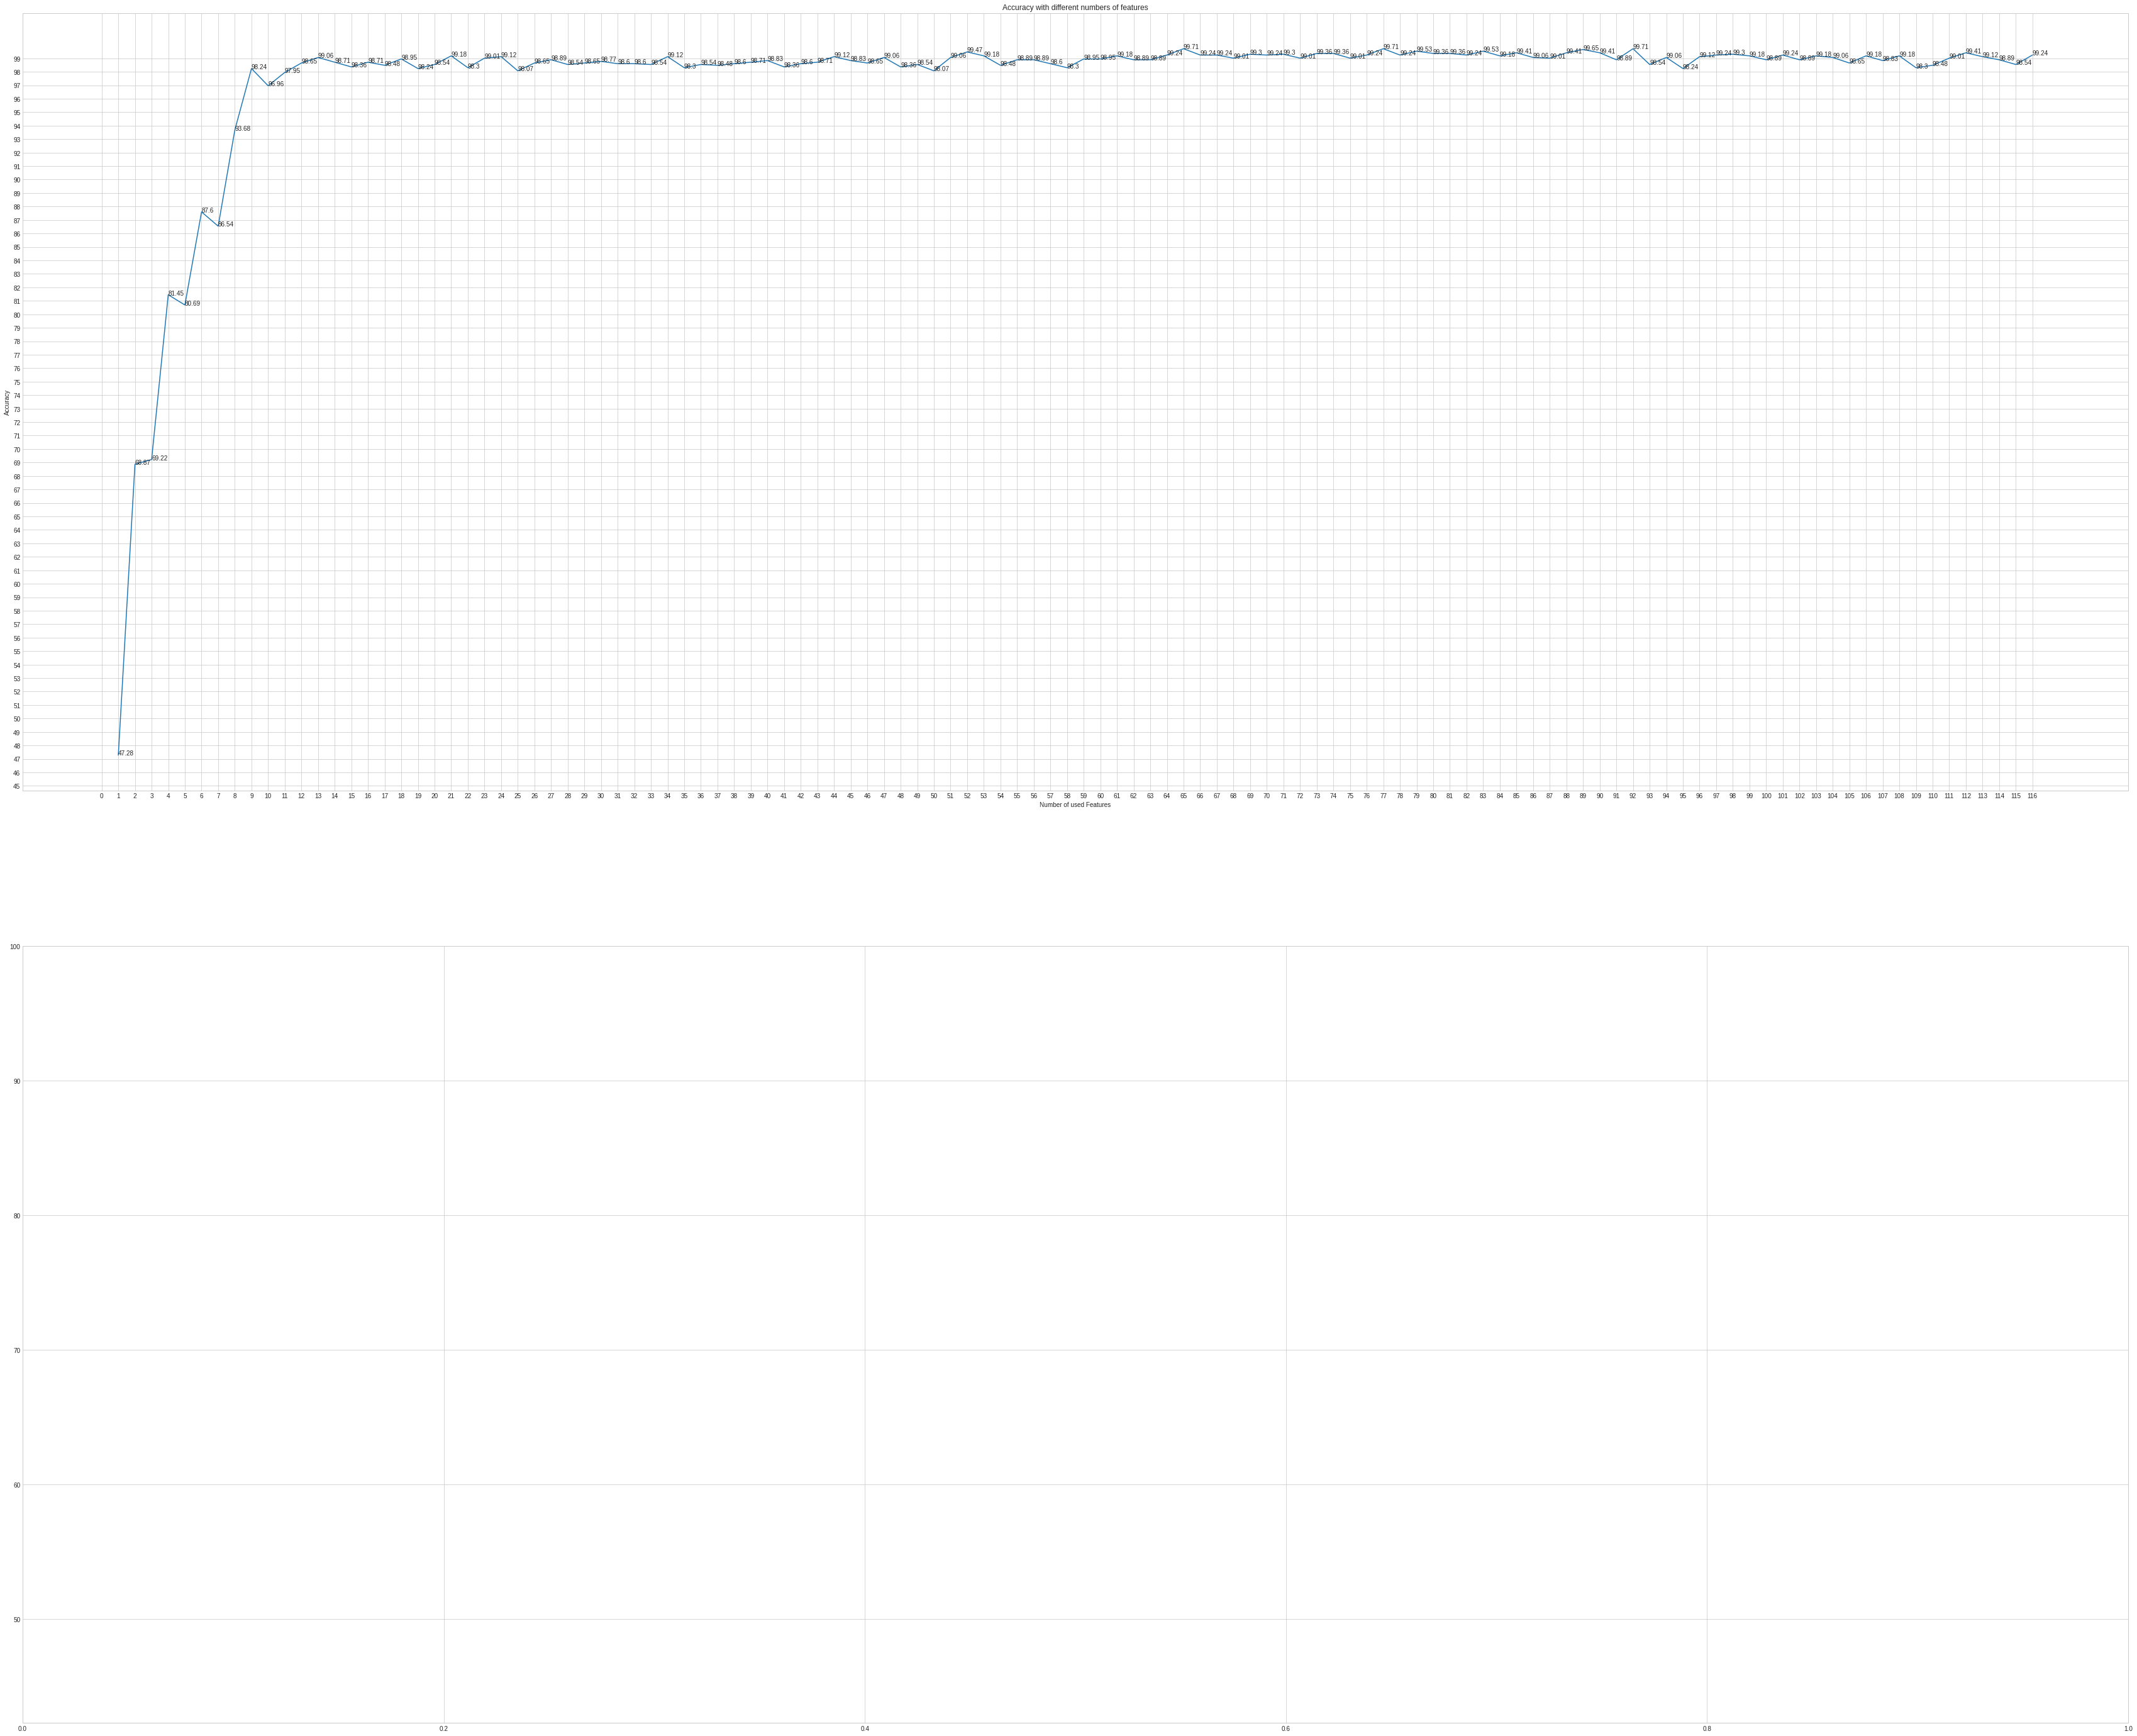

98.93295238095239


In [52]:
plt.style.use('seaborn-whitegrid')
fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(60, 50)
ax1.set_title("Accuracy with different numbers of features")
ax1.set_ylabel("Accuracy")
ax1.set_yticks(np.arange(0, 100, 1))
ax1.set_xlabel("Number of used Features")
ax1.set_xticks(np.arange(0, len(feature_numbers)+1, 1))

ax1.plot(feature_numbers,accuracy_list)


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

accuracy_list_moving_average =  np.concatenate((accuracy_list[0:4], moving_average(accuracy_list, 5)))
# ax.plot(feature_numbers,accuracy_list_moving_average)
# ax.bar(feature_numbers,accuracy_list, width=0.3)
# ax.text(1, -15, text, verticalalignment ='center_baseline', fontsize='large' , bbox={'facecolor': 'white', 'pad': 0})
# # plt.plot(feature_numbers, accuracy_list)
for i,j in zip(feature_numbers,accuracy_list):
    ax1.annotate(str(j),xy=(i,j))

plt.ylim([np.min(accuracy_list) - 5,100])
plt.show()

file_name ='Accuracy of the model with different number of features on dataset {}.jpg'.format(chosen_dataset_name)
save_path = "{}/{}".format(basic_saving_dir, file_name)
fig.savefig(save_path, dpi=100)
print(np.average(accuracy_list[11:]))

In [12]:
# Running two model with two data set default model is random forest. evaluate acc with another dataset
g_label_2 = GroupedLabels(total_possible_labels=90)

levels_merged_ssd_round_11_df = g_label_2.grouped_levels_cate(df=ssd_round_11_df)
levels_merged_hdd_round_12_df = g_label_2.grouped_levels_cate(df=hdd_round_12_df)


model_obj = Model_Run()
model_obj.compare_two_dataset(levels_merged_ssd_round_11_df, levels_merged_hdd_round_12_df, model_name="")
# print("Accuracy of the model {} on dataset {} is after merging different levels".format(a_model.model_to_name[a_model.model_name], chosen_dataset_name), a_model.run_model(df=levels_merged_df))

# levels_merged_rf_model = a_model.generate_with_all(levels_merged_x_dtns_train, levels_merged_y_dtns_train)

	Accuracy: 0.7531355523396044


	Accuracy: 0.8154476301930954


In [ ]:

mean = np.average(importances)
percentile_amount = 50
threshold = np.percentile(importances, percentile_amount)
bool_array = importances > threshold
clipped_importances = importances[bool_array]
clipped_feature_names = feature_names[bool_array]
clipped_std = std[bool_array]
print(len(clipped_importances))
print(len(clipped_std))

forest_importances_clipped = pd.Series(clipped_importances, index=clipped_feature_names)
fig, ax = plt.subplots()
forest_importances_clipped.plot.bar(yerr=clipped_std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.set_size_inches(50, 25)
fig.savefig('grouped_all_levels_{}_percentile_dataset_{}_feature_importance.jpeg'.format(percentile_amount,
                                                                                         chosen_dataset_name), dpi=100)
fig.tight_layout()

In [ ]:

# clipped_forest_importances = pd.Series(clipped_importances, index=clipped_feature_names)
# fig2, ax2 = plt.subplots()
# forest_importances.plot.bar(yerr=std, ax=ax2)
# ax2.set_title("Feature importances using MDI")
# ax2.set_ylabel("Mean decrease in impurity")
# fig2.set_size_inches(50, 25)
# fig2.savefig('test_importance_18.jpeg', dpi=100)
# fig2.tight_layout()


In [ ]:
# Creating a model (classifier) with train dataset
# self.model_to_name = {"RF": "Random Forest", "DT": "Decision Tree", "MLP": "MLP Classifier",
#                       "KN": "KNeighborsClassifier", "QDA": "QuadraticDiscriminantAnalysis", "NB": "GaussianNB",
#                       "ADA": "AdaBoostClassifier", "svm": "SVM", "sdg": "SGDClassifier"}
data_set_1_classifier = a.generate_with_all(x_dtns_train, y_dtns_train, model_name="RF")
data_set_2_classifier = a.generate_with_all(x_dtns_train, y_dtns_train)

#Comparing the accuracy of model on different dataset
a.compare_two_dataset(dtns_df, dtns_df, model_name="RF")


In [ ]:
# dtns_df.describe()
dtns_df.iloc[:, 14:30].describe()

In [ ]:
# Get the correlation of the data
correlation = dtns_df.corr()
f, axes = plt.subplots(figsize=(40, 20))
#diverging color map generate
cmap = sns.diverging_palette(150, 275, as_cmap=True)

sns.heatmap(correlation, cmap=cmap, center=0, linewidth=1, cbar_kws={"shrink": 0.5})

plt.title('Correlation Matrix Heatmap')

In [ ]:
#Get the columns name in the dataset
dtns_df.columns

In [ ]:
#Cahnge Nans in correlation with false and true, get the name of the columns that have correlation true.
nan_corr = list(correlation.cwnd_rate[~correlation.loc[['cwnd_rate'], :].isna().any()].index.values)


In [ ]:
sns.pairplot(x_vars=nan_corr, y_vars='cwnd_rate', data=dtns_df.loc[dtns_df['label_value'] == 0], height=5)
plt.show()